# Introduction 

## Using linear regression algorithm to forecast store sales

In [1]:
# Setup
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

data_dir = Path('/Users/ezan/desktop/time-series-forcasting/data/ts-course-data/')
comp_dir = Path('//Users/ezan/desktop/time-series-forcasting/data/store-sales-time-series-forcasting/')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

book_sales

/var/folders/r7/5r4ycx9n5d1fd_my0s23cyy40000gp/T/ipykernel_41551/255914381.py:31: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


Hardcover  Time  Lag_1
Date                              
2000-04-01        139     0    NaN
2000-04-02        128     1  139.0
2000-04-03        172     2  128.0
2000-04-04        139     3  172.0
2000-04-05        191     4  139.0
2000-04-06        168     5  191.0
2000-04-07        170     6  168.0
2000-04-08        145     7  170.0
2000-04-09        184     8  145.0
2000-04-10        135     9  184.0
2000-04-11        218    10  135.0
2000-04-12        198    11  218.0
2000-04-13        230    12  198.0
2000-04-14        222    13  230.0
2000-04-15        206    14  222.0
2000-04-16        240    15  206.0
2000-04-17        189    16  240.0
2000-04-18        222    17  189.0
2000-04-19        158    18  222.0
2000-04-20        178    19  158.0
2000-04-21        217    20  178.0
2000-04-22        261    21  217.0
2000-04-23        238    22  261.0
2000-04-24        240    23  238.0
2000-04-25        214    24  240.0
2000-04-26        200    25  214.0
2000-04-27        201    26  200.0
2000-04-28        283    27  201.0
2000-04-29        220    28  283.0
2000-04-30        259    29  220.0

--------------------------------------------------------------------------------

In the model `target = weight * feature + bias`, the `weight` tells you by how much the `target` changes on average for each unit of change in the `feature`.



# linear regression on *Hardcover Sales*.

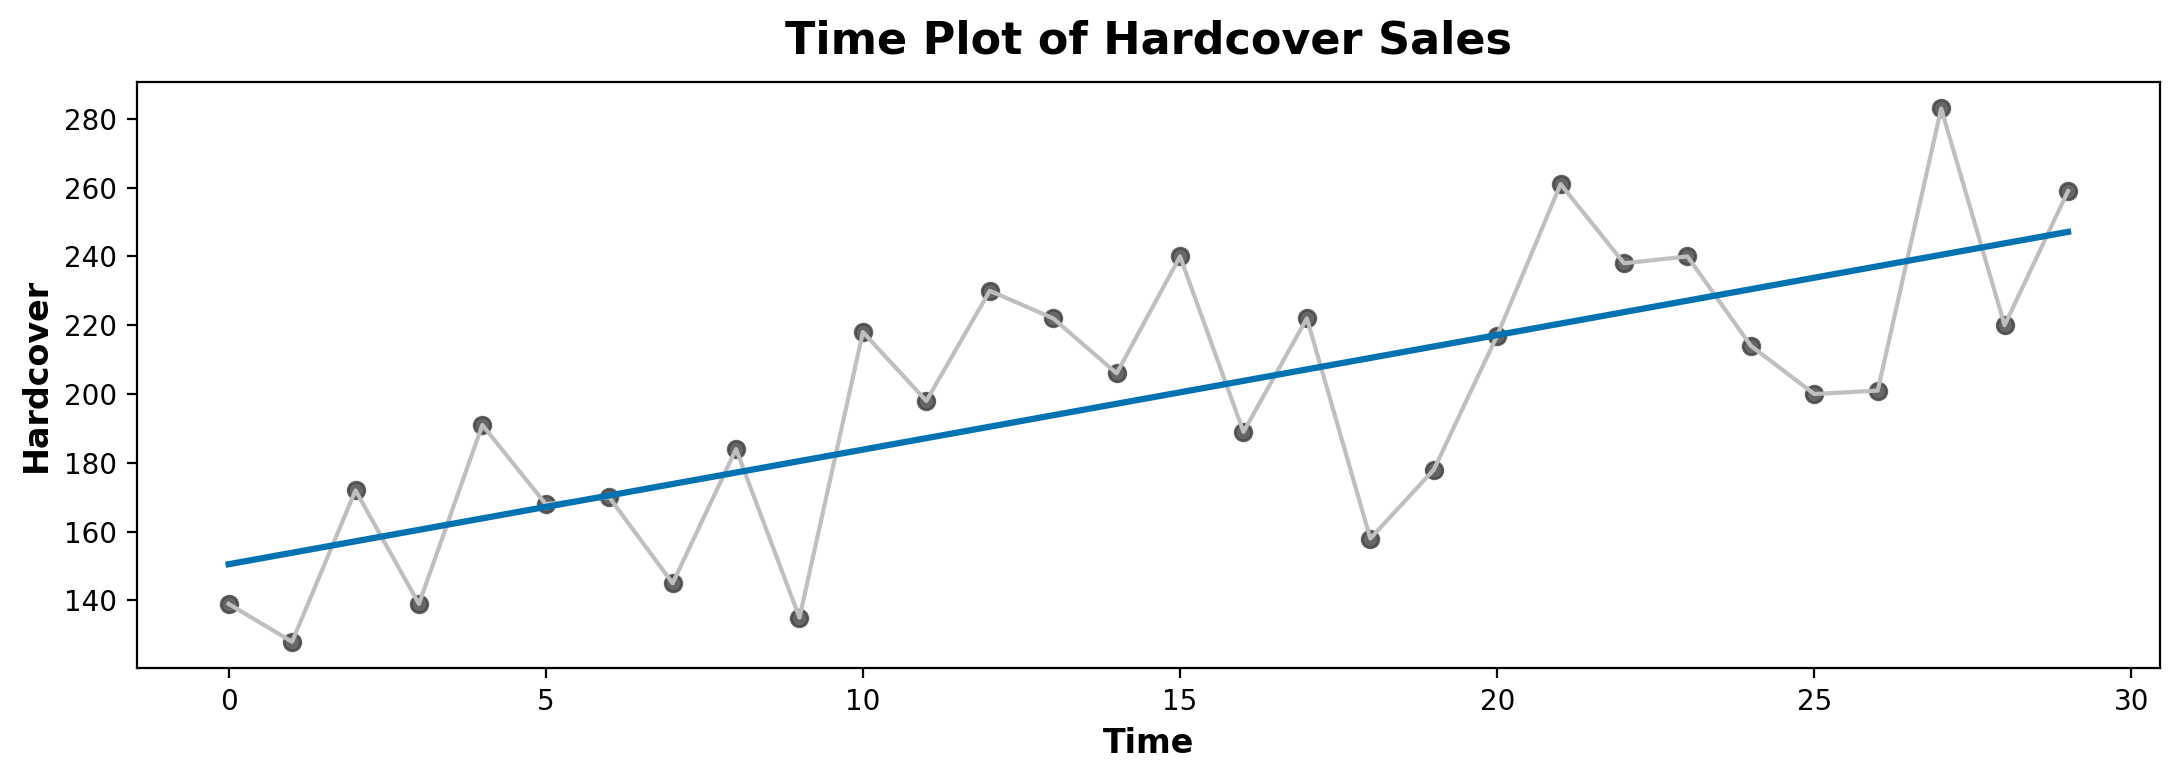

In [2]:
plt.style.use("seaborn-v0_8-colorblind")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'


fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

# 1) Interpret linear regression with the time dummy

The linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. Over 6 days how much on average would you expect hardcover sales to change?.

In [3]:
# View the solution (Run this line to receive credit!)
from sklearn.linear_model import LinearRegression

# Training data
X = book_sales.loc[:, ['Time']]  # features
y = book_sales.loc[:, 'Hardcover']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

#Print the coefficients
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

# Predict the weight for a height of 170 cm
x = 5  # of books in the prediction
time = np.array([[x]])
weight = model.predict(time)


Intercept: 150.53978494623658
Slope: 3.330589543937707


/Users/ezan/anaconda3/envs/Dev/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [5]:
# A change of 6 steps in Time corresponds to an average change of 6 * 3.33 = 19.98 in Hardcover sales.

y_average = 3.33 * 6
y_average


19.98

-------------------------------------------------------------------------------

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells you how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.

# 2) Interpret linear regression with a lag feature

Two series generated according to the model just described.

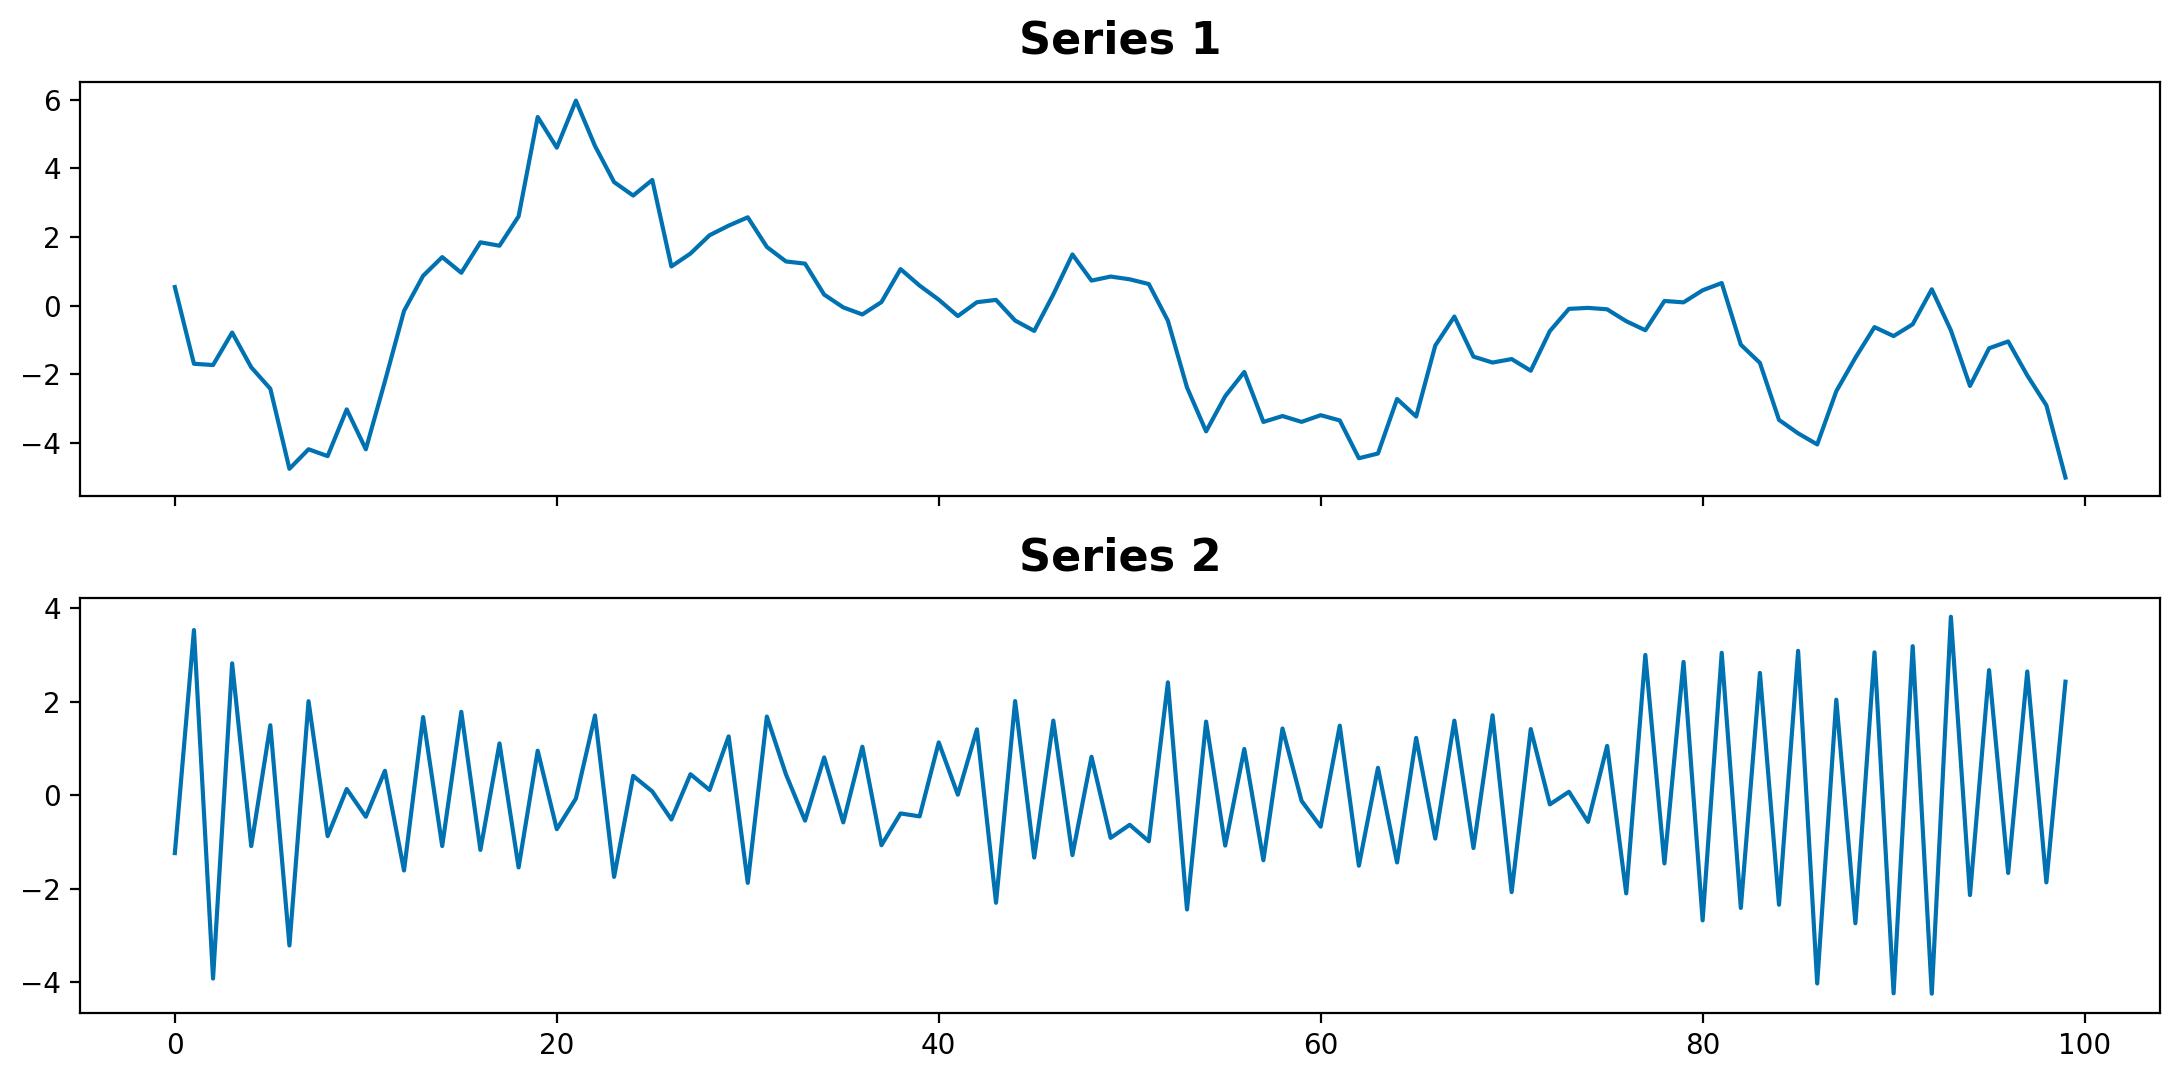

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, differing only by the sign on the lag feature. Can you tell which equation goes with each series?

In [7]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))
df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)



Plot of the result.

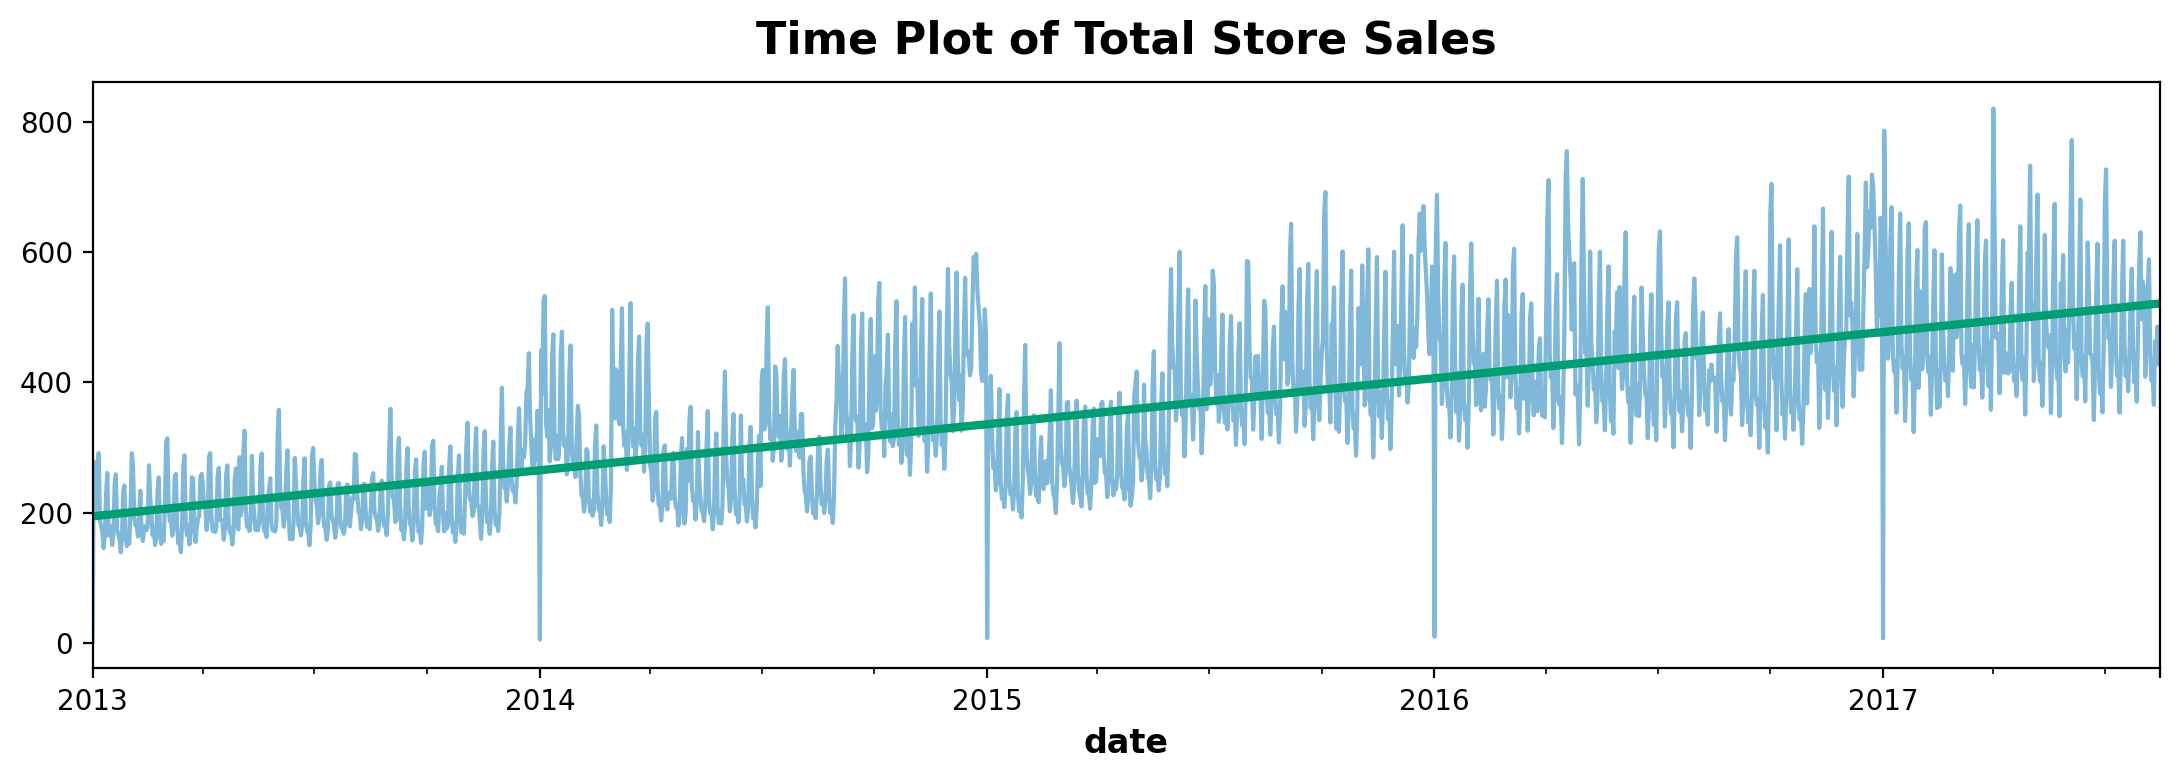

In [8]:
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Fit a lag feature to Store Sales

Complete the code below to create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [9]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)



Run the next cell if you'd like to see the result.

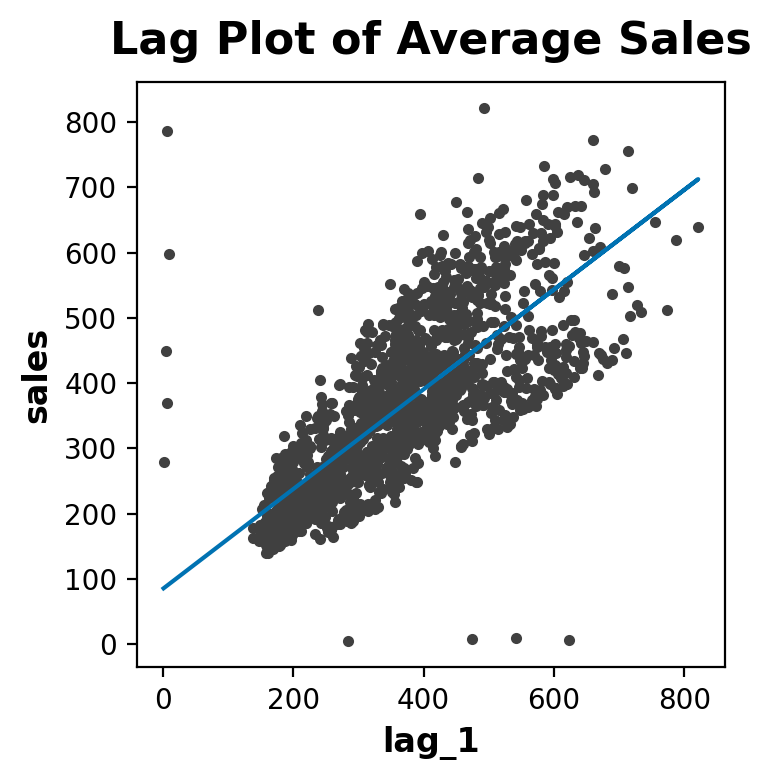

In [10]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');